In [79]:
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

%matplotlib inline

### Optimise Your Pub Crawl

Travelling Salesman Problem (TSP) using simulated annealing for finding the shortest route between pubs in galway

In [80]:
class pub_crawl:
    def __init__(self, df, G) -> None:
        self.df = df
        self.G = G

        self.pub_names = df['name'].to_list()
        self.initial_route = self.pub_names

        self.optimal_route = None
        self.optimal_distance = None

        self.pub_nodes = self.create_pub_nodes()
        self.distance_matrix = self.create_distance_matrix()
    
    def create_pub_nodes(self):
        # create dictionary of pub names and coordinates
        pubs_dict = self.df.drop('address', axis=1).set_index('name').T.to_dict('list')

        # Get graph nodes for each pub
        pub_nodes = {}
        for k, v in pubs_dict.items():
            pub_nodes[k] = ox.nearest_nodes(self.G, X = v[1], Y = v[0])
        
        return pub_nodes
    
    def get_route_length(self, p0, p1):
        route = nx.shortest_path(self.G, self.pub_nodes[p0], self.pub_nodes[p1], weight='length')
        route_lengths = ox.utils_graph.get_route_edge_attributes(self.G, route, attribute = 'length')
        route_length_total = sum(route_lengths)
        return route_length_total

    def create_distance_matrix(self):
        distance_matrix = []
        for i in range(len(self.pub_names)):
            row = []
            for j in range(len(self.pub_names)):
                distance = self.get_route_length(self.pub_names[i], self.pub_names[j])
                row.append(distance*100)
            distance_matrix.append(row)
        
        return distance_matrix
    
    def plot_map(self):
        node_colours = ['#FF0000' if i in list(self.pub_nodes.values()) else '#999999' for i in self.G.nodes]
        fig, ax = ox.plot_graph(self.G, bgcolor='#FFFFFF', node_color=node_colours, show=False, close=False)
        for _, node in ox.graph_to_gdfs(self.G, nodes=True, edges=False).fillna("").iterrows():
            for k, v in self.pub_nodes.items():
                if node.name == v:
                    c = node["geometry"].centroid
                    ax.annotate(k, xy=(c.x, c.y), xycoords='data', xytext=(3, -2), textcoords='offset points', size=8)
        plt.show()
    
    def get_route_nodes(self, route):
        route_nodes = []
        for i in range(len(route)-1):
            path = nx.shortest_path(self.G, self.pub_nodes[route[i]], self.pub_nodes[route[i+1]], weight='length')
            route_nodes.append(path)
        return route_nodes
    
    def plot_route(self, route):
        # Plot route
        route_nodes = self.get_route_nodes(route)
        fig, ax = ox.plot_graph_routes(self.G, route_nodes, bgcolor='#FFFFFF', show=False, close=False)
        for _, node in ox.graph_to_gdfs(self.G, nodes=True, edges=False).fillna("").iterrows():
            for i, k in enumerate(route):
                if node.name == self.pub_nodes[k]:
                    c = node["geometry"].centroid
                    ax.annotate(f'{i}: {k}', xy=(c.x, c.y), xycoords='data', xytext=(3, -2), textcoords='offset points', size=8)
        plt.show()
    
    def create_data(self, start):
        data = {}
        start_index = self.pub_names.index(start)
        data['distance_matrix'] = self.distance_matrix
        data['num_vehicles'] = 1
        data['depot'] = start_index
        return data
    
    def format_solution(self, manager, routing, solution):
        """Formats solution for osmnx."""
        index = routing.Start(0)
        route = [index]

        leg_distances = []
        route_distance = 0
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            if route[0] == manager.IndexToNode(index):
                break
            route.append(manager.IndexToNode(index))
            leg_distance = routing.GetArcCostForVehicle(previous_index, index, 0)
            leg_distances.append(leg_distance)
            route_distance += leg_distance
        
        self.optimal_route = [self.pub_names[i] for i in route]
        self.optimal_distance = route_distance/100
    
    def optimise(self, start_point):

        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]
        
        data = self.create_data(start_point)

        # Create the routing index manager
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                                data['num_vehicles'], data['depot'])

        # Create Routing Model
        routing = pywrapcp.RoutingModel(manager)

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
        search_parameters.time_limit.seconds = 5
        search_parameters.log_search = True

        # Solve the problem
        solution = routing.SolveWithParameters(search_parameters)

        # Format solution
        if solution:
            self.format_solution(manager, routing, solution)

Locations of pubs in Galway to consider:


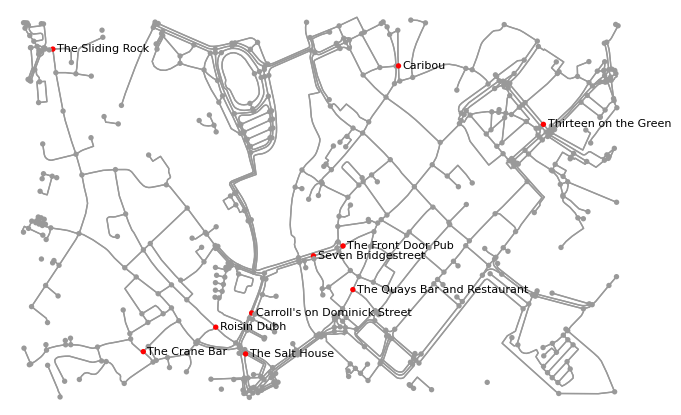

Initial route before optimisation (default pub ordering):


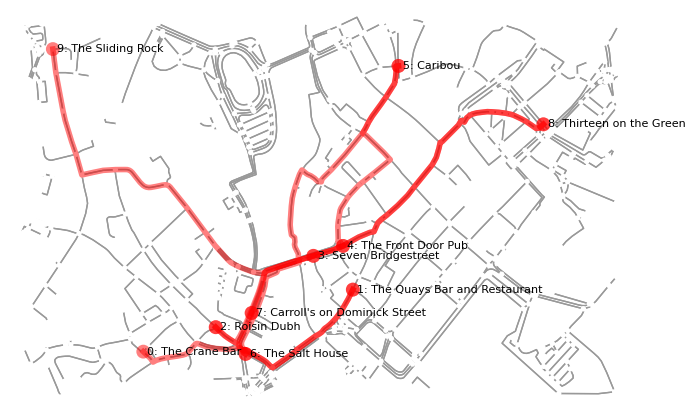

Optimised route:


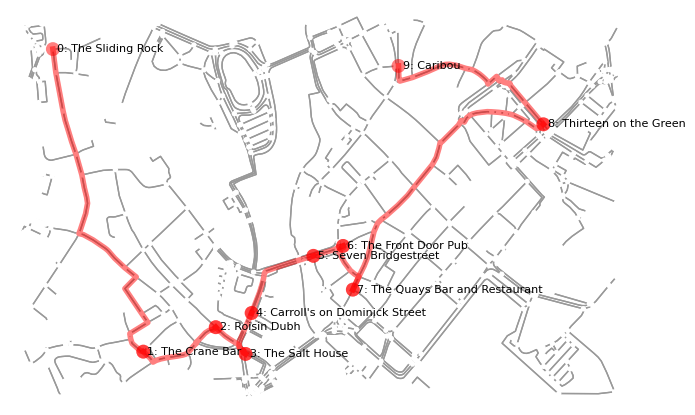

Route distance: 2558.2 meters


In [81]:
df = pd.read_csv('galway_pubs.csv')
G =  ox.io.load_graphml('galway.graphml')

crawler = pub_crawl(df, G)

print('Locations of pubs in Galway to consider:')
crawler.plot_map()

initial_route = crawler.initial_route

print('Initial route before optimisation (default pub ordering):')
crawler.plot_route(initial_route)

start_pub = 'The Sliding Rock'
crawler.optimise(start_pub)

optimal_route = crawler.optimal_route
print('Optimised route:')
crawler.plot_route(optimal_route)

print(f'Route distance: {crawler.optimal_distance} meters')
